
### Objectiu del departament d'Anàlisi de Perfil Client:

> Quines combinacions de característiques demogràfiques (com edat, nivell educatiu i ocupació) són més comunes entre els clients que utilitzen múltiples productes financers del banc: loan, hipoteca, dipòsit?

### Llibreries i càrrega de dades

In [26]:
%pip install plottable
%pip install kmodes
%pip install yellowbrick
%pip install numpy scipy statsmodels


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [ ]:
"""Libreries que poden ser necessàries"""

# Manejo de datos
import pandas as pd                 # Análisis y manipulación de datos en tablas
import numpy as np                  # Cálculos numéricos y matrices
import os                           # Gestión de rutas de archivos

# Visualización de datos
import matplotlib.pyplot as plt     # Gráficos básicos en 2D
import seaborn as sns               # Gráficos estadísticos mejorados
import plotly.express as px         # Gráficos interactivos simplificados
import plotly.graph_objects as go   # Control avanzado de gráficos en Plotly
import plotly.io as pio             # Interfaz de entrada/salida de Plotly
import squarify                     # Visualización de diagramas de "treemap"
from plottable import Table         # Visualización de tablas
import matplotlib.colors as mcolors # Colores y mapas de colores

# Clustering y agrupamiento
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.decomposition import PCA
from kmodes.kmodes import KModes
from kmodes.kprototypes import KPrototypes
from sklearn.preprocessing import StandardScaler
from yellowbrick.cluster import KElbowVisualizer
from statsmodels.multivariate.manova import MANOVA



In [28]:
df = pd.read_csv("../Data/df_250526.csv")

Paleta de colors

In [29]:
custom_palette = ["#AABBC8", "#2CCED1", "#5F6F81", "#DCE3EA", "#2E2F36"]  
sns.set_palette(sns.color_palette(custom_palette))

### Extracte KPIs

In [30]:

# Variables 
contactados   = df.nunique().id                                     # Número total de clientes contactados
suscribieron  = df[df['deposit'] == True].nunique().id             # Número de clientes que suscribieron 
duracion_llam = df[df['deposit'] == True].duration.sum()           # Duración de llamadas a suscriptores
llam_telf = df[df['contact'] == 'telephone']['campaign'].sum()      # Número de llamadas realizadas por teléfono
llam_cell = df[df['contact'] == 'cellular']['campaign'].sum()       # Número de llamadas realizadas por movil
llam = df['campaign'].sum()                                         # Número total de llamadas
contatos_previos_sus = df[df['deposit'] == True]['previous'].sum() # Número de contactos previos a suscriptores
suscribieron_por_mes = df[df['deposit'] == True].groupby('month').count()['deposit']  # Suscriptores en el mes
contactos_por_mes = df.groupby('month').count()['deposit']          # clientes contactados en el mes      
conversion_por_mes = suscribieron_por_mes / contactos_por_mes       # conversión por mes


# Prints
print("El número total de clientes contactados es:",contactados)
print("El número de suscriptores es:",suscribieron)
print("La duración total de las llamadas a suscriptores es:",duracion_llam)
print("El número de llamadas realizadas a teléfono fijo es: ", llam_telf)
print("El número de llamadas realizadas a móvil es: ", llam_cell)
print("El número total de llamadas realizadas es: ", llam)
print("El número total de contactos previos de los suscriptores es:", contatos_previos_sus)
print("La conversión por mes es: ", conversion_por_mes)

El número total de clientes contactados es: 26180
El número de suscriptores es: 12499
La duración total de las llamadas a suscriptores es: 6763175
El número de llamadas realizadas a teléfono fijo es:  5399
El número de llamadas realizadas a móvil es:  45476
El número total de llamadas realizadas es:  65801
El número total de contactos previos de los suscriptores es: 14668
La conversión por mes es:  month
Apr    0.630156
Aug    0.456259
Dec    0.902344
Feb    0.576944
Jan    0.409548
Jul    0.413754
Jun    0.446554
Mar    0.903374
May    0.334334
Nov    0.426036
Oct    0.838816
Sep    0.844941
Name: deposit, dtype: float64


In [31]:
#KPIs
kpi1 = suscribieron/contactados          # porcentaje de conversión a depósito
kpi2 = duracion_llam/suscribieron        # promedio de duración de llamadas a suscriptores
kpi3_tel = llam_telf/llam                # porcentaje de llamadas a teléfono
kpi3_cell = llam_cell/llam               # porcentaje de llamadas a móvil
kpi3 = (llam_telf+llam_cell)/llam        # porcentaje de llamadas a teléfono o móvil
kpi4 = contatos_previos_sus/suscribieron # promedio de contactos previos a suscriptores
kpi5 = conversion_por_mes.idxmax()       # mes con mayor tasa de conversión
kpi5_tasa = conversion_por_mes.max()     # tasa de conversión del mes con mayor tasa de conversión




# Prints
print("KPI 1: El porcentaje de conversión a depósito es ",kpi1*100,"%")
print("KPI 2: La duración media de las llamadas a suscriptoreses",kpi2)
# print("KPI 3: El porcentaje de llamadas realizadas por teléfono o móvil es ",kpi3*100,"%")
print("KPI 3.1: El porcentaje de llamadas realizadas por teléfono fijo es ",kpi3_tel*100,"%")
print("KPI 3.2: El porcentaje de llamadas realizadas por teléfono móvil es ",kpi3_cell*100,"%")
print("KPI 4: El porcentaje de contactos previos a suscriptores es ",kpi4)
print("KPI 5: El mes amb millor conversió ha sigut", kpi5, "amb una taxa de conversió de", kpi5_tasa)

KPI 1: El porcentaje de conversión a depósito es  47.74255156608098 %
KPI 2: La duración media de las llamadas a suscriptoreses 541.0972877830227
KPI 3.1: El porcentaje de llamadas realizadas por teléfono fijo es  8.205042476558107 %
KPI 3.2: El porcentaje de llamadas realizadas por teléfono móvil es  69.11141168067356 %
KPI 4: El porcentaje de contactos previos a suscriptores es  1.1735338827106168
KPI 5: El mes amb millor conversió ha sigut Mar amb una taxa de conversió de 0.9033742331288344


# Anàlisi 

### Càlcul per a clients que no han contractat res

In [32]:
# Número de clients que van suscriure, tenen prèstec i una hipoteca 
df_0contractats = df[(df['deposit'] == False) & (df['loan'] == False) & (df['housing'] == False)] 

df_0contractats_numero = df_0contractats.nunique().id 
print("El número de clientes que no suscribieron, no tienen préstamo ni hipoteca es:", df_0contractats_numero)


# Agrupem el dataframe per la combinació de les característiques demogràfiques 
df_0contractats = df_0contractats.groupby(['age', 'education','job'])


# Creem una taula per al càlcul de conversions
taula_pefils_0contractats = []

# Recorrem la taula calculant la conversió de cada grup
for (edat, educacio, feina), grup in df_0contractats:
    numero = grup.nunique().id

    # Afegim cada resultat a la taula
    taula_pefils_0contractats.append({
        'age': edat,
        'education': educacio,
        'job': feina,
        'número': numero,
    })

# Convertim la taula de conversió en un dataframe 
taula_pefils_0contractats = pd.DataFrame(taula_pefils_0contractats)

# taula_pefils = taula_pefils.set_index(['feina', 'estat_civil', 'educació'])  # Establim l'índex de la taula

# Ordenem per 
taula_pefils_0contractats = taula_pefils_0contractats.sort_values(by='número', ascending=False)  # Ordenem la taula per número de persones

# Reordenem les columnes de la taula

taula_pefils_0contractats.head(15)  # Mostrem les primeres 15 files de la taula

El número de clientes que no suscribieron, no tienen préstamo ni hipoteca es: 4928


,age,education,job,número
152,33,tertiary,management,82
98,30,tertiary,management,74
117,31,tertiary,management,70
135,32,tertiary,management,60
170,34,tertiary,management,55
112,31,secondary,technician,48
209,36,tertiary,management,46
166,34,secondary,technician,45
288,40,tertiary,management,45
95,30,secondary,technician,41


### Càlcul per a clients que han contractat només un producte


In [33]:
# Crear una nova columna temporal que compta quants productes ha contractat el client
df['productes_contractats'] = df[['deposit', 'loan', 'housing']].sum(axis=1)

# Filtrar els clients que n'han contractat exactament un
df_1contractats = df[df['productes_contractats'] == 1].copy()


df_1contractats_numero = df_1contractats.nunique().id 
print("El número de clientes que o bien suscribieron, o bien tienen préstamo o hipoteca es:", df_1contractats_numero)


# Agrupem el dataframe per la combinació de les característiques demogràfiques 
df_1contractats = df_1contractats.groupby(['age', 'education','job'])


# Creem una taula per al càlcul de conversions
taula_pefils_1contractats = []

# Recorrem la taula calculant la conversió de cada grup
for (edat, educacio, feina), grup in df_1contractats:
    numero = grup.nunique().id

    # Afegim cada resultat a la taula
    taula_pefils_1contractats.append({
        'age': edat,
        'education': educacio,
        'job': feina,
        'número': numero,
    })

# Convertim la taula de conversió en un dataframe 
taula_pefils_1contractats = pd.DataFrame(taula_pefils_1contractats)

# taula_pefils = taula_pefils.set_index(['feina', 'estat_civil', 'educació'])  # Establim l'índex de la taula

# Ordenem per 
taula_pefils_1contractats = taula_pefils_1contractats.sort_values(by='número', ascending=False)  # Ordenem la taula per número de persones

# Reordenem les columnes de la taula

taula_pefils_1contractats.head(15)  # Mostrem les primeres 15 files de la taula


El número de clientes que o bien suscribieron, o bien tienen préstamo o hipoteca es: 14777


,age,education,job,número
214,31,tertiary,management,176
348,36,tertiary,management,170
267,33,tertiary,management,161
295,34,tertiary,management,150
187,30,tertiary,management,147
240,32,tertiary,management,146
320,35,tertiary,management,144
374,37,tertiary,management,134
161,29,tertiary,management,106
135,28,tertiary,management,95


### Càlcul per a clients que han contractat més d'un producte


In [34]:
# Filtrar els clients que n'han contractat més d’un (>=2)
df_mes_dun_contractat = df[df['productes_contractats'] >= 2].copy()

# Eliminar la columna temporal si no cal
df_mes_dun_contractat.drop(columns='productes_contractats', inplace=True)


df_mes_dun_contractat_numero = df_mes_dun_contractat.nunique().id 
print("El número de clientes que contrataron dos o más productes entre suscribirse, préstamo o hipoteca es:", df_mes_dun_contractat_numero)


# Agrupem el dataframe per la combinació de les característiques demogràfiques 
df_mes_dun_contractat = df_mes_dun_contractat.groupby(['age', 'education','job'])


# Creem una taula per al càlcul de conversions
taula_df_mes_dun_contractat = []

# Recorrem la taula calculant la df_mes_dun_contractat de cada grup
for (edat, educacio, feina), grup in df_mes_dun_contractat:
    numero = grup.nunique().id

    # Afegim cada resultat a la taula
    taula_df_mes_dun_contractat.append({
        'age': edat,
        'education': educacio,
        'job': feina,
        'número': numero,
    })

# Convertim la taula de conversió en un dataframe 
taula_df_mes_dun_contractat = pd.DataFrame(taula_df_mes_dun_contractat)

# taula_pefils = taula_pefils.set_index(['feina', 'estat_civil', 'educació'])  # Establim l'índex de la taula

# Ordenem per 
taula_df_mes_dun_contractat = taula_df_mes_dun_contractat.sort_values(by='número', ascending=False)  # Ordenem la taula per número de persones

# Reordenem les columnes de la taula

taula_df_mes_dun_contractat.head(15)  # Mostrem les primeres 15 files de la taula



El número de clientes que contrataron dos o más productes entre suscribirse, préstamo o hipoteca es: 6475


,age,education,job,número
214,35,tertiary,management,99
171,33,tertiary,management,72
136,31,tertiary,management,72
127,31,secondary,blue-collar,71
289,39,tertiary,management,67
194,34,tertiary,management,67
154,32,tertiary,management,63
110,30,secondary,blue-collar,63
202,35,secondary,blue-collar,55
183,34,secondary,blue-collar,55


### Verificació dels tres grups

In [35]:
print("El número de clientes que no suscribieron, no tienen préstamo ni hipoteca es:", df_0contractats_numero)
print("El número de clientes que o bien suscribieron, o bien tienen préstamo o hipoteca es:", df_1contractats_numero)
print("El número de clientes que contrataron dos o más productes entre suscribirse, préstamo o hipoteca es:", df_mes_dun_contractat_numero)

print("La suma de los anteriores es", df_0contractats_numero + df_1contractats_numero + df_mes_dun_contractat_numero)


print("El total de clientes contactados es", df.nunique().id)


El número de clientes que no suscribieron, no tienen préstamo ni hipoteca es: 4928
El número de clientes que o bien suscribieron, o bien tienen préstamo o hipoteca es: 14777
El número de clientes que contrataron dos o más productes entre suscribirse, préstamo o hipoteca es: 6475
La suma de los anteriores es 26180
El total de clientes contactados es 26180


## Elbow method para encontrar k óptimo
Calculo el costo para diferentes valores de l entre 2 - 9 (inclusive)

https://es.wikipedia.org/wiki/M%C3%A9todo_del_codo_(agrupamiento)
El método consiste en graficar la variación explicada en función del número de conglomerados y elegir el codo de la curva como el número de conglomerados a utilizar. Utilizar el "codo" o la "rodilla de una curva" como punto de corte es un método común en la optimización matemática para elegir aquel punto a partir del cual los rendimientos decrecientes ya no justifican el costo adicional.

En este caso, el codo está en el 3.

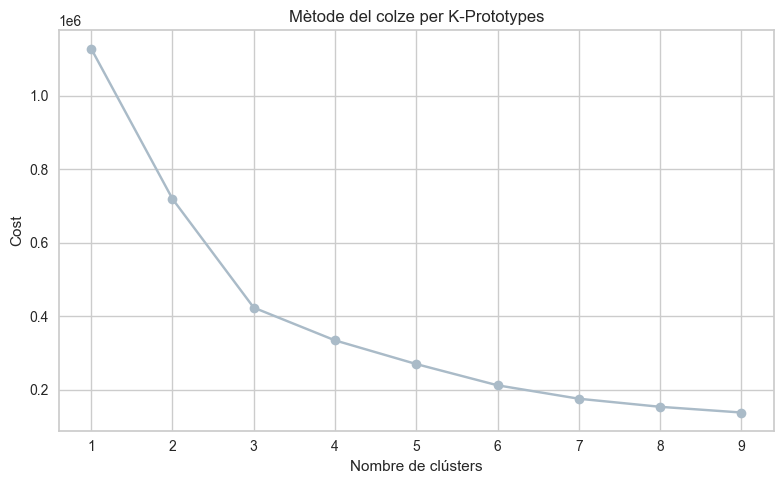

In [36]:
# Unim les tres taules
df_clusters = pd.concat([
    taula_pefils_0contractats.assign(contractats='Cap'),
    taula_pefils_1contractats.assign(contractats='Un'),
    taula_df_mes_dun_contractat.assign(contractats='Més d\'un')
], ignore_index=True)

# Preparem les dades per clusteritzar
X = df_clusters[['número', 'age', 'education', 'job', 'contractats']].copy()
X[['job', 'education', 'contractats']] = X[['job', 'education', 'contractats']].astype(str)

# Fem un encode per a les categories
X_encoded = X.copy()
X_encoded[['job', 'education', 'contractats']] = X_encoded[['job', 'education', 'contractats']].astype(str)

# Elbow method amb KPrototypes
X_matrix = X_encoded[['número', 'age', 'job', 'education', 'contractats']].values

costs = []
K_range = range(1, 10)
for k in K_range:
    kproto = KPrototypes(n_clusters=k, init='Cao', verbose=0)
    kproto.fit_predict(X_matrix, categorical=[2, 3, 4])
    costs.append(kproto.cost_)

# Dibuixar el gràfic del mètode del colze
plt.figure(figsize=(8,5))
plt.plot(K_range, costs, marker='o')
plt.xlabel('Nombre de clústers')
plt.ylabel('Cost')
plt.title('Mètode del colze per K-Prototypes')
plt.xticks(K_range)
plt.grid(True)
plt.tight_layout()
plt.show()



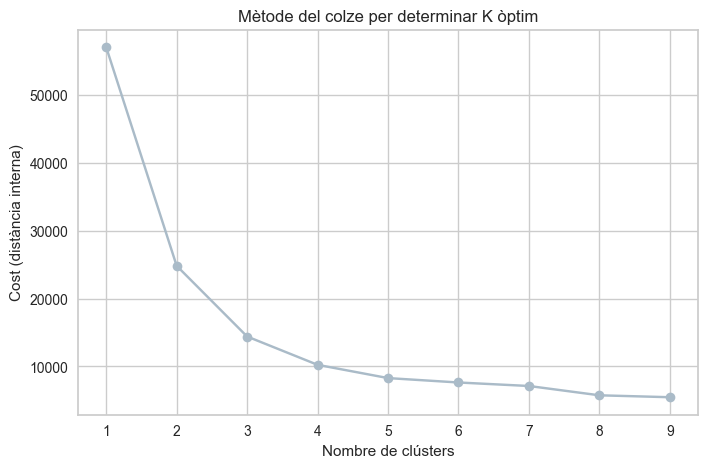

In [37]:

# Seleccionem les columnes rellevants
X = taula_pefils_0contractats[['número', 'job', 'education']].copy()
X[['job', 'education']] = X[['job', 'education']].astype(str)

costs = []
K = range(1, 10)

for k in K:
    kproto = KPrototypes(n_clusters=k, init='Cao', verbose=0, random_state=42)
    kproto.fit_predict(X, categorical=[1, 2])
    costs.append(kproto.cost_)

# Dibuixar el gràfic del colze
plt.figure(figsize=(8, 5))
plt.plot(K, costs, marker='o')
plt.xlabel('Nombre de clústers')
plt.ylabel('Cost (distància interna)')
plt.title('Mètode del colze per determinar K òptim')
plt.grid(True)
plt.show()

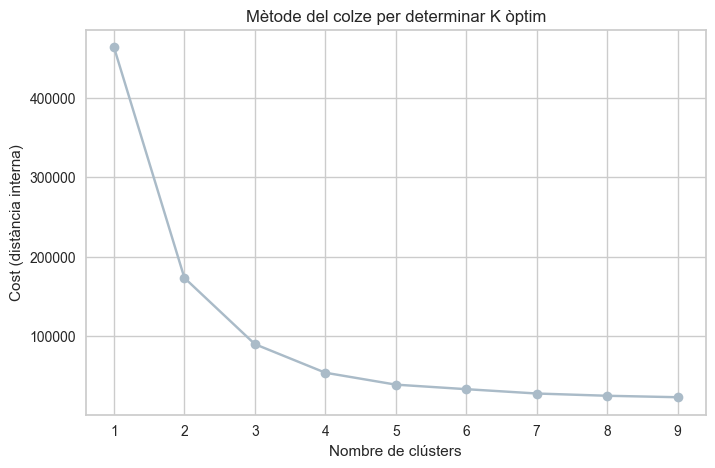

In [38]:
# Seleccionem les columnes rellevants
X = taula_pefils_1contractats[['número', 'job', 'education']].copy()
X[['job', 'education']] = X[['job', 'education']].astype(str)

costs = []
K = range(1, 10)

for k in K:
    kproto = KPrototypes(n_clusters=k, init='Cao', verbose=0, random_state=42)
    kproto.fit_predict(X, categorical=[1, 2])
    costs.append(kproto.cost_)

# Dibuixar el gràfic del colze
plt.figure(figsize=(8, 5))
plt.plot(K, costs, marker='o')
plt.xlabel('Nombre de clústers')
plt.ylabel('Cost (distància interna)')
plt.title('Mètode del colze per determinar K òptim')
plt.grid(True)
plt.show()

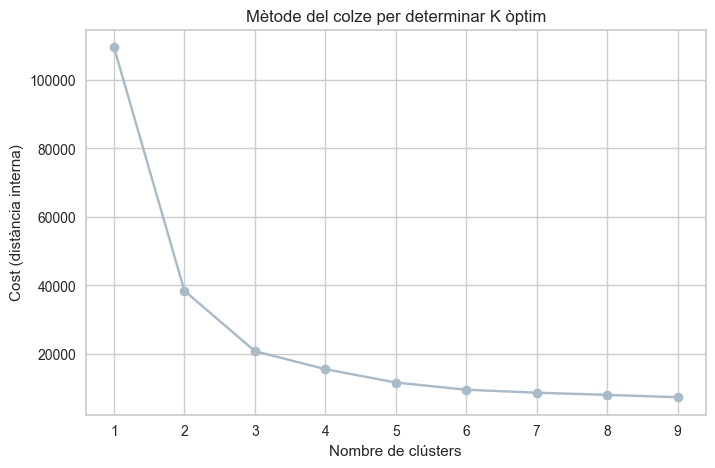

In [39]:
# Seleccionem les columnes rellevants
X = taula_df_mes_dun_contractat[['número', 'job', 'education']].copy()
X[['job', 'education']] = X[['job', 'education']].astype(str)

costs = []
K = range(1, 10)

for k in K:
    kproto = KPrototypes(n_clusters=k, init='Cao', verbose=0, random_state=42)
    kproto.fit_predict(X, categorical=[1, 2])
    costs.append(kproto.cost_)

# Dibuixar el gràfic del colze
plt.figure(figsize=(8, 5))
plt.plot(K, costs, marker='o')
plt.xlabel('Nombre de clústers')
plt.ylabel('Cost (distància interna)')
plt.title('Mètode del colze per determinar K òptim')
plt.grid(True)
plt.show()

## Clusteritació i centroides

Aplquem KMeans amb 3 cluster per a cadascun d'aquests grups

In [40]:

# =======================
# Grup 1: 0 productes
# =======================
X0 = taula_pefils_0contractats[['age', 'education', 'job']]
encoder_0 = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
X0_encoded = encoder_0.fit_transform(X0[['education', 'job']])
X0_numeric = np.column_stack([X0['age'].values, X0_encoded])

kmeans_0 = KMeans(n_clusters=3, random_state=42)
clusters_0 = kmeans_0.fit_predict(X0_numeric)
taula_pefils_0contractats['cluster'] = clusters_0

# Centroides
df_centroides_0 = pd.DataFrame(
    kmeans_0.cluster_centers_,
    columns=['age'] + list(encoder_0.get_feature_names_out(['education', 'job']))
)

# =======================
# Grup 2: 1 producte
# =======================
X1 = taula_pefils_1contractats[['age', 'education', 'job']]
encoder_1 = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
X1_encoded = encoder_1.fit_transform(X1[['education', 'job']])
X1_numeric = np.column_stack([X1['age'].values, X1_encoded])

kmeans_1 = KMeans(n_clusters=3, random_state=42)
clusters_1 = kmeans_1.fit_predict(X1_numeric)
taula_pefils_1contractats['cluster'] = clusters_1

# Centroides
df_centroides_1 = pd.DataFrame(
    kmeans_1.cluster_centers_,
    columns=['age'] + list(encoder_1.get_feature_names_out(['education', 'job']))
)

# =======================
# Grup 3: 2 o més productes
# =======================
X2 = taula_df_mes_dun_contractat[['age', 'education', 'job']]
encoder_2 = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
X2_encoded = encoder_2.fit_transform(X2[['education', 'job']])
X2_numeric = np.column_stack([X2['age'].values, X2_encoded])

kmeans_2 = KMeans(n_clusters=3, random_state=42)
clusters_2 = kmeans_2.fit_predict(X2_numeric)
taula_df_mes_dun_contractat['cluster'] = clusters_2

# Centroides
df_centroides_2 = pd.DataFrame(
    kmeans_2.cluster_centers_,
    columns=['age'] + list(encoder_2.get_feature_names_out(['education', 'job']))
)


In [41]:
df_centroides_0

,age,education_primary,education_secondary,education_tertiary,education_unknown,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown
0,46.685246,0.229508,0.406557,0.216393,0.147541,0.088525,0.137705,0.081967,0.095082,0.127869,0.052459,0.081967,0.081967,6.557377e-03,0.127869,0.068852,0.049180
1,62.642105,0.289474,0.373684,0.215789,0.121053,0.073684,0.078947,0.047368,0.078947,0.110526,0.368421,0.052632,0.042105,-4.163336e-17,0.063158,0.052632,0.031579
2,31.281250,0.132812,0.437500,0.335937,0.093750,0.105469,0.113281,0.042969,0.066406,0.113281,0.003906,0.070312,0.101562,1.484375e-01,0.113281,0.093750,0.027344


In [42]:
df_centroides_1

,age,education_primary,education_secondary,education_tertiary,education_unknown,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown
0,32.056911,0.166667,0.359756,0.315041,0.158537,0.107724,0.126016,0.071138,0.050813,0.105691,0.006098,0.083333,0.119919,1.158537e-01,0.109756,0.083333,0.020325
1,51.109195,0.256705,0.340996,0.222222,0.180077,0.099617,0.114943,0.078544,0.086207,0.137931,0.086207,0.072797,0.090038,3.831418e-03,0.118774,0.082375,0.028736
2,71.230769,0.272727,0.314685,0.244755,0.167832,0.027972,0.020979,0.034965,0.097902,0.090909,0.594406,0.041958,0.000000,-2.081668e-17,0.048951,0.020979,0.020979


In [43]:
df_centroides_2

,age,education_primary,education_secondary,education_tertiary,education_unknown,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown
0,55.995261,0.246445,0.407583,0.227488,0.118483,0.090047,0.113744,0.094787,0.047393,0.156398,1.848341e-01,0.056872,0.094787,-3.469447e-17,0.123223,0.028436,9.478673e-03
1,28.848485,0.156566,0.469697,0.313131,0.060606,0.136364,0.166667,0.075758,0.025253,0.126263,-1.387779e-17,0.101010,0.111111,7.070707e-02,0.131313,0.055556,-2.168404e-18
2,41.066667,0.239216,0.431373,0.243137,0.086275,0.117647,0.149020,0.117647,0.062745,0.137255,7.843137e-03,0.074510,0.101961,1.176471e-02,0.137255,0.082353,-4.336809e-19


### Interpretació dels centroides

Anem a interpretar els centroides dels 3 grups per veure els perfils típics dels clients en cada clúster:

##### Grup 0: Clients sense contracte (df_centroides_0)

| Clúster | Edat mitjana  | Educació dominant          | Feina destacada                                                | Perfil resumit                                                    |
| ------- | ------------- | -------------------------- | -------------------------------------------------------------- | ----------------------------------------------------------------- |
| 0       | **46,7 anys** | **Secundària (0.41)**      | Variada, lleuger predomini de **blue-collar** i **technician** | Adults actius, classe treballadora, estudis mitjans               |
| 1       | **62,6 anys** | **Primària i secundària**  | **Retirats (0.37)**                                            | Gent gran, força jubilats, estudis bàsics                         |
| 2       | **31,3 anys** | **Secundària i terciària** | **Estudiants (0.15)**, tècnics, serveis                        | Joves, amb estudis més alts, orientats a feina tècnica o formació |


##### Grup 1: Clients amb 1 contracte (df_centroides_1)


| Clúster | Edat mitjana  | Educació dominant          | Feina destacada                  | Perfil resumit                                                        |
| ------- | ------------- | -------------------------- | -------------------------------- | --------------------------------------------------------------------- |
| 0       | **32 anys**   | **Secundària i terciària** | **Tècnic, estudiant, serveis**   | Joves actius, qualificats, propensos a iniciar relació amb el banc    |
| 1       | **51,1 anys** | **Secundària**             | **Management, tècnics, serveis** | Adults consolidats, amb certa responsabilitat laboral                 |
| 2       | **71,2 anys** | **Secundària i primària**  | **Retirats (0.59)**              | Gent gran amb 1 producte, probablement pensions o productes d'estalvi |


##### Grup 2: Clients amb 2+ contractes (df_centroides_2)

| Clúster | Edat mitjana  | Educació dominant          | Feina destacada                   | Perfil resumit                                                      |
| ------- | ------------- | -------------------------- | --------------------------------- | ------------------------------------------------------------------- |
| 0       | **56 anys**   | **Secundària**             | **Retirats, management**          | Adults grans consolidats, molt probablement amb productes complexos |
| 1       | **28,8 anys** | **Secundària i terciària** | **Blue-collar, tècnics, serveis** | Joves amb alta activitat i capacitat contractant                    |
| 2       | **41 anys**   | **Secundària**             | **Blue-collar, tècnics**          | Adults actius amb estabilitat laboral, probablement clients clau    |


#### Conclusions generals
Els clients amb més productes (grup 2) tendeixen a estar en franges d'edat mitjana o avançada, amb estudis secundaris i professions estables.

Els més joves (20–35 anys) apareixen en tots els grups, però amb perfils més estudiantils o tècnics, sovint amb només 0 o 1 contracte.

Els retirats tenen una presència clara en els tres grups, però són molt més actius (més productes) quan tenen una edat avançada i una certa estabilitat.



## Hi ha diferència? Si

MANOVA (Multivariate ANOVA)

La MANOVA permet avaluar si hi ha diferències multivariades entre els grups en múltiples variables (com l’edat, tipus d’educació, ocupació, etc.).

Ho podem fer perquè tenim una matriu amb totes les observacions individuals (no només els centroides) i una etiqueta de grup (grup = 0, 1 o 2 segons nombre de contractes).

Pr > F molt petita (p.ex. < 0.05): hi ha diferències significatives entre els grups pel conjunt de variables.

Wilks' lambda proper a 0: els grups estan ben separats.


 Hipòtesi nul·la de la MANOVA:
Les mitjanes vectorials (centroides) de totes les variables independents són iguals per als diferents grups.

Hi ha una diferència significativa entre almenys un dels grups de clients pel que fa als seus perfils (considerant edat, educació i ocupació).

✳️ És a dir, els clients que no contracten res, els que contracten una vegada, i els que contracten dues o més vegades tenen, en mitjana, profils multivariants significativament diferents.


In [45]:


# 1. Combinem els tres grups i assignem valors
taula_pefils_0contractats['grup'] = 0
taula_pefils_1contractats['grup'] = 1
taula_df_mes_dun_contractat['grup'] = 2

df_total = pd.concat([
    taula_pefils_0contractats,
    taula_pefils_1contractats,
    taula_df_mes_dun_contractat
])

# 2. One-hot encoding
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
X_encoded = encoder.fit_transform(df_total[['education', 'job']])

# 3. Combinar amb edat
X_numeric = np.column_stack([df_total['age'].values, X_encoded])

# 4. Noms de columnes (amb substitució segura de caràcters problemàtics)
columnes_originals = ['age'] + list(encoder.get_feature_names_out(['education', 'job']))
columnes_net = [col.replace('.', '_').replace('-', '_') for col in columnes_originals]

# 5. Crear dataframe per MANOVA
df_manova = pd.DataFrame(X_numeric, columns=columnes_net)
df_manova['grup'] = df_total['grup'].values

# 6. Crear la fórmula
features_formula = ' + '.join(columnes_net)
formula = f'{features_formula} ~ grup'

# 7. Apliquem MANOVA
manova = MANOVA.from_formula(formula, data=df_manova)

# 8. Resultats
print(manova.mv_test())


                                Multivariate linear model
                                                                                          
------------------------------------------------------------------------------------------
       Intercept               Value         Num DF   Den DF         F Value        Pr > F
------------------------------------------------------------------------------------------
          Wilks' lambda              0.0000 16.0000 2555.0000 8108746241830855.0000 0.0000
         Pillai's trace              1.1131 16.0000 2555.0000            -1571.6612 1.0000
 Hotelling-Lawley trace 45035996273704.0859 16.0000 2555.0000 7191685654957121.0000 0.0000
    Roy's greatest root 45035996273703.9609 16.0000 2555.0000 7191685654957101.0000 0.0000
------------------------------------------------------------------------------------------
                                                                                          
--------------------------------

## Quines diferències hi ha?

Anem a fer MANOVAs per parells de grups per veure quins grups són significativament diferents entre si.

📦 Abans de començar
Ja tenim el df_manova preparat, amb:
- Les variables codificades i netes com a columnes
- La columna grup amb valors 0, 1, 2


p-value < 0.05 → Els dos grups tenen perfils diferents
p-value > 0.05 → No hi ha diferències estadísticament significatives





In [47]:

# 1. Definim la fórmula (igual que abans)
features_formula = ' + '.join(df_manova.columns.difference(['grup']))
formula = f'{features_formula} ~ grup'

# 2. Funció per aplicar MANOVA entre 2 grups
def manova_dos_grups(df, grup_a, grup_b):
    df_filtrat = df[df['grup'].isin([grup_a, grup_b])].copy()
    print(f"\n--- MANOVA per grup {grup_a} vs grup {grup_b} ---")
    model = MANOVA.from_formula(formula, data=df_filtrat)
    print(model.mv_test())

# 3. Comparacions per parells
manova_dos_grups(df_manova, 0, 1)
manova_dos_grups(df_manova, 0, 2)
manova_dos_grups(df_manova, 1, 2)



--- MANOVA per grup 0 vs grup 1 ---
                               Multivariate linear model
                                                                                        
----------------------------------------------------------------------------------------
       Intercept              Value         Num DF   Den DF        F Value        Pr > F
----------------------------------------------------------------------------------------
          Wilks' lambda             0.0000 16.0000 1891.0000 351972703481799.3750 0.0000
         Pillai's trace             1.1487 16.0000 1891.0000            -912.7253 1.0000
 Hotelling-Lawley trace 2535096891285.6909 16.0000 1891.0000 299616763838827.6250 0.0000
    Roy's greatest root 2535096891285.5161 16.0000 1891.0000 299616763838806.9375 0.0000
----------------------------------------------------------------------------------------
                                                                                        
----------------

Conclusions:

No hi ha diferències estadísticament significatives entre els grups 0 i 1.
Sí hi ha diferències significatives entre els grups 0 i 2.
També hi ha diferències significatives entre els grups 1 i 2.

El grup 2 (els amb més d’un contractat, imagino?) és diferent dels altres dos.
Els grups 0 i 1 (cap i un contractat) són semblants entre si.


## Gràfiques

gràfic de dispersió 2D de l’anàlisi LDA (Linear Discriminant Analysis) després d’una MANOVA. Aquest codi mostrarà com es distribueixen els grups (0, 1, 2) en funció de les dues primeres components discriminants:



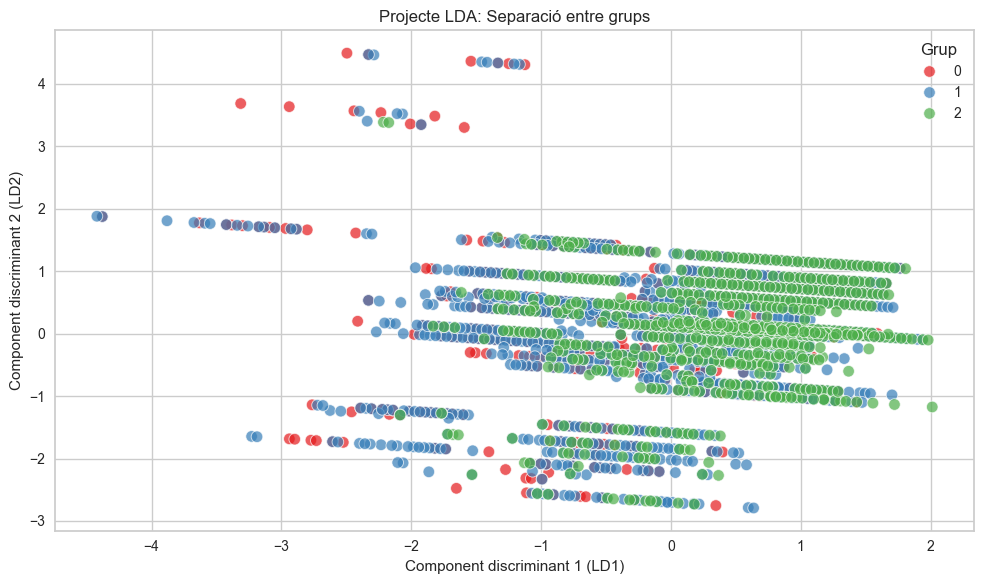

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import OneHotEncoder

# 1. Preparem les dades (com abans)
df_total = pd.concat([
    taula_pefils_0contractats.assign(grup=0),
    taula_pefils_1contractats.assign(grup=1),
    taula_df_mes_dun_contractat.assign(grup=2)
])

# 2. Codifiquem les variables categòriques
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
X_encoded = encoder.fit_transform(df_total[['education', 'job']])

# 3. Combineu amb edat
X = np.column_stack([df_total['age'].values, X_encoded])
y = df_total['grup'].values

# 4. Apliquem LDA
lda = LinearDiscriminantAnalysis(n_components=2)
X_lda = lda.fit_transform(X, y)

# 5. Creem un DataFrame per a graficar
df_lda = pd.DataFrame(X_lda, columns=['LD1', 'LD2'])
df_lda['grup'] = y

# 6. Gràfic
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_lda,
    x='LD1',
    y='LD2',
    hue='grup',
    palette='Set1',
    alpha=0.7,
    s=70
)
plt.title('Projecte LDA: Separació entre grups')
plt.xlabel('Component discriminant 1 (LD1)')
plt.ylabel('Component discriminant 2 (LD2)')
plt.legend(title='Grup')
plt.grid(True)
plt.tight_layout()
plt.show()


Biplot de càrregues LDA

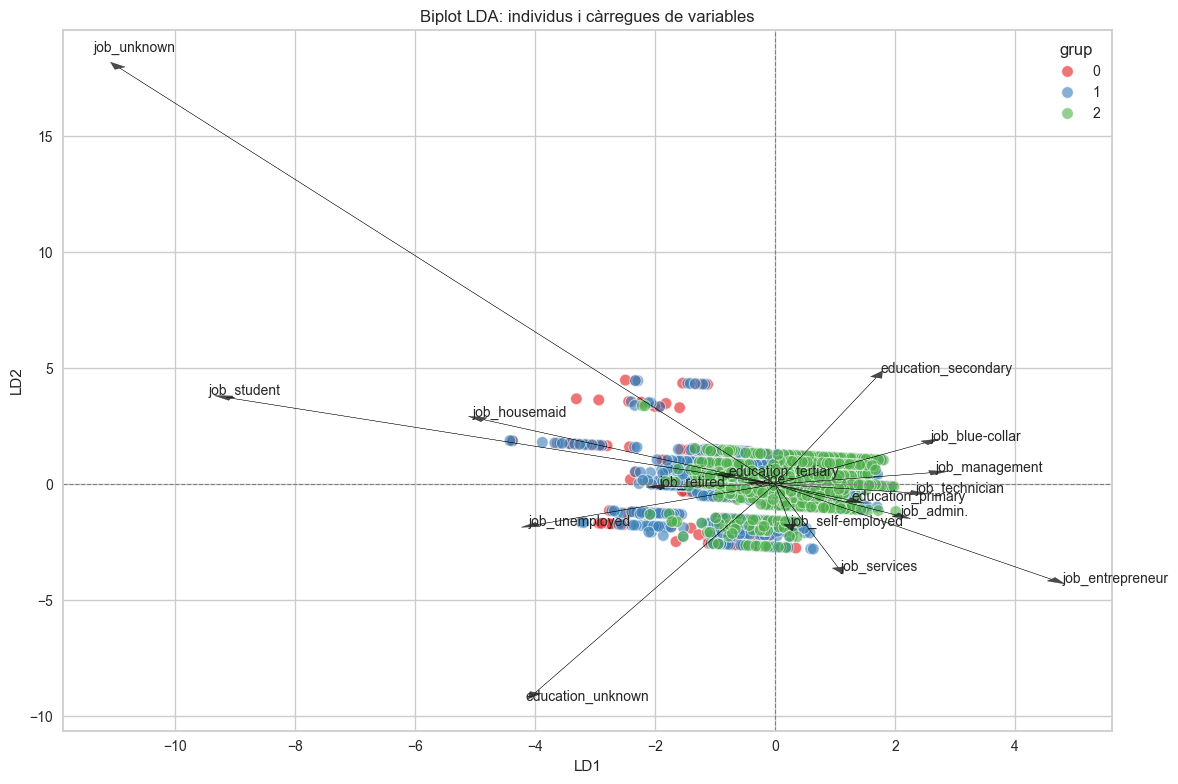

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import OneHotEncoder

# Codificació de les variables i combinació
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
X_encoded = encoder.fit_transform(df_total[['education', 'job']])
X = np.column_stack([df_total['age'].values, X_encoded])
y = df_total['grup'].values

# Noms de les columnes
features = ['age'] + list(encoder.get_feature_names_out(['education', 'job']))

# LDA
lda = LinearDiscriminantAnalysis(n_components=2)
X_lda = lda.fit_transform(X, y)

# Càrregues (coeficients)
loadings = lda.scalings_[:, :2]  # només primeres 2 components

# Crear el biplot
plt.figure(figsize=(12, 8))

# Punts projectats
df_plot = pd.DataFrame(X_lda, columns=['LD1', 'LD2'])
df_plot['grup'] = y
sns.scatterplot(data=df_plot, x='LD1', y='LD2', hue='grup', palette='Set1', alpha=0.6, s=70)

# Afegim fletxes de les variables (càrregues)
for i, feature in enumerate(features):
    plt.arrow(0, 0,  # origen
              loadings[i, 0]*5, loadings[i, 1]*5,  # escalat per visibilitat
              color='black', alpha=0.7, head_width=0.2)
    plt.text(loadings[i, 0]*5.2, loadings[i, 1]*5.2, feature, fontsize=10)

plt.title('Biplot LDA: individus i càrregues de variables')
plt.xlabel('LD1')
plt.ylabel('LD2')
plt.grid(True)
plt.axhline(0, color='gray', linestyle='--', linewidth=0.8)
plt.axvline(0, color='gray', linestyle='--', linewidth=0.8)
plt.tight_layout()
plt.show()


Gràfic de barres circular

Cada gràfic mostra la distribució percentual dels tipus de job dins de cada grup.

Mostra tres gràfics de barres circulars, un per cada grup (grup == 0, 1, 2).

La longitud de cada barra representa el percentatge de cada job dins del grup.

Utilitza una paleta de color des de gris fosc fins a turquesa per mostrar millor la magnitud.



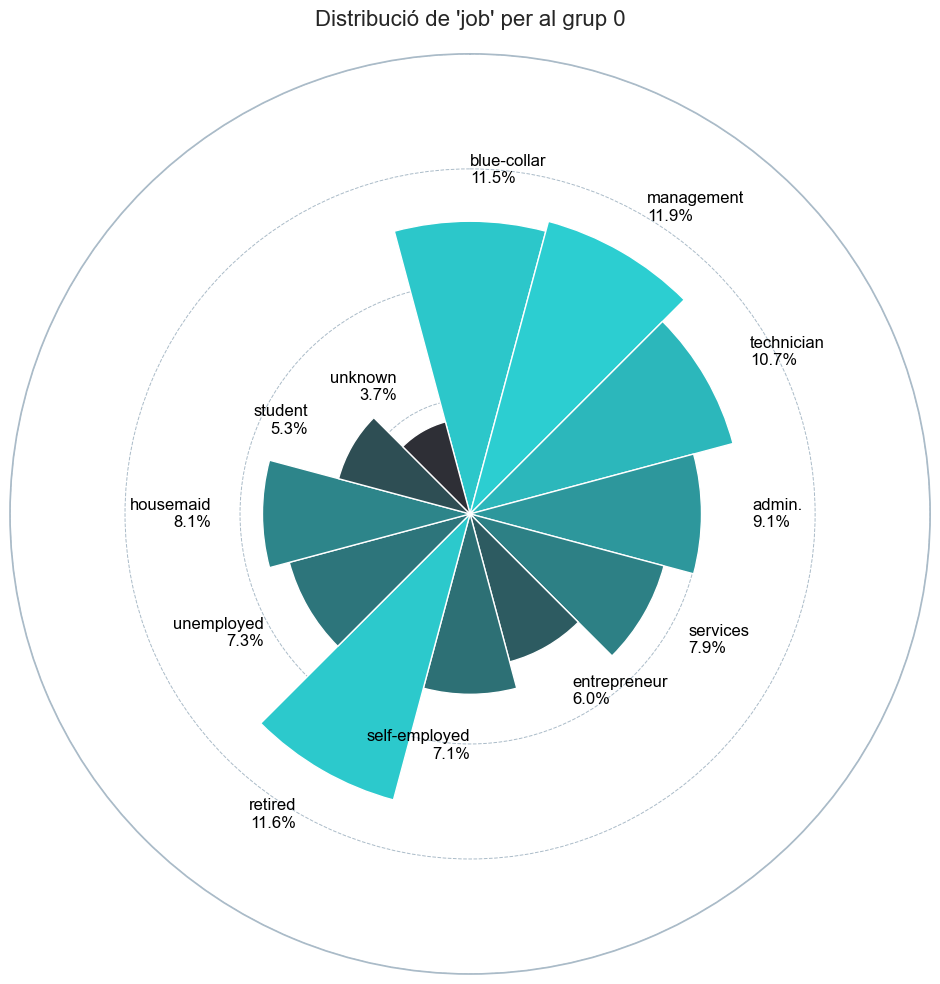

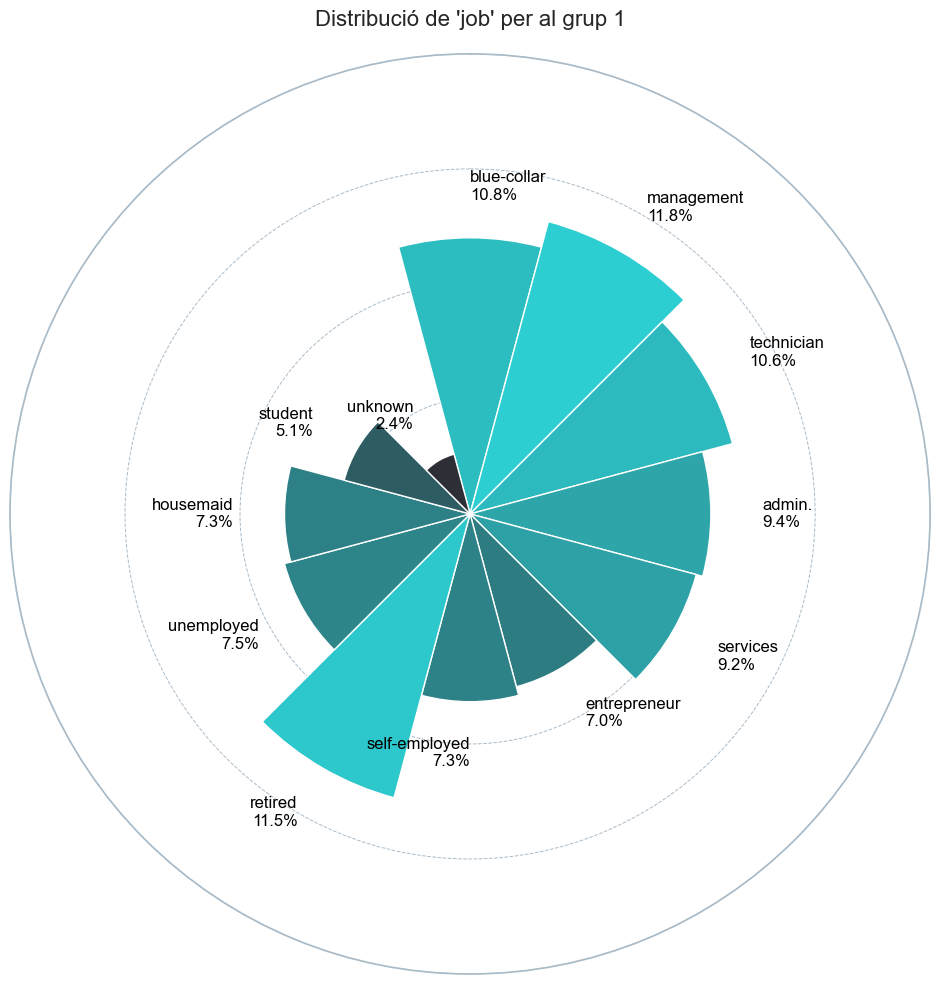

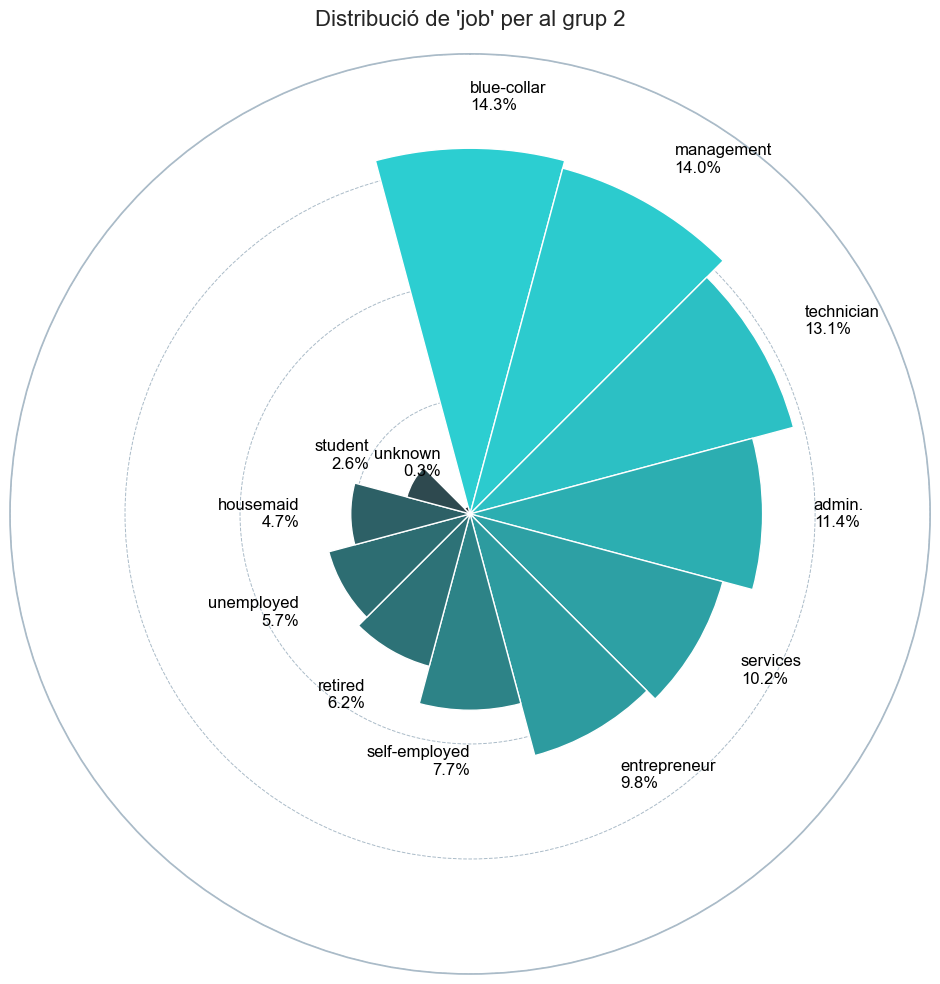

In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Pas 1: Definir l'ordre de job segons el grup 2
df_g2 = df_total[df_total['grup'] == 2]
totals_g2 = df_g2['job'].value_counts(normalize=True) * 100
ordre_jobs = totals_g2.sort_values(ascending=False).index.tolist()

# Pas 2: Funció per fer el gràfic per a un grup donat seguint l'ordre de grup 2
def plot_circular_bar_for_group(df, grup_num, ordre_jobs):
    df_grup = df[df['grup'] == grup_num]
    
    # Comptar percentatges per job dins del grup
    totals_per_job = df_grup['job'].value_counts()
    percentatge_job = (totals_per_job / totals_per_job.sum()) * 100

    # Reordenar segons ordre de grup 2 i omplir amb 0 si falta algun job
    percentatge_reordenat = pd.Series({job: percentatge_job.get(job, 0) for job in ordre_jobs})

    # Paleta de colors
    norm = plt.Normalize(percentatge_reordenat.min(), percentatge_reordenat.max())
    cmap = mcolors.LinearSegmentedColormap.from_list("custom", ["#2E2F36", "#2CCED1"])
    colors = [cmap(norm(v)) for v in percentatge_reordenat]

    # Configuració polar
    N = len(percentatge_reordenat)
    angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()
    values = percentatge_reordenat.tolist()
    labels = ordre_jobs

    # Per fer el cercle complet
    angles += angles[:1]
    values += values[:1]
    colors += colors[:1]
    labels += labels[:1]

    # Crear gràfic
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'polar': True})
    
    bars = ax.bar(
        angles[:-1], values[:-1], width=2*np.pi/N, color=colors[:-1], edgecolor='white', linewidth=1
    )

    # Etiquetes
    for angle, value, label in zip(angles[:-1], values[:-1], labels[:-1]):
        rotation = np.degrees(angle)
        alignment = 'left' if rotation < 180 else 'right'
        ax.text(
            angle,
            value + 2,
            f"{label}\n{value:.1f}%",
            ha=alignment,
            va='center',
            rotation=0,
            rotation_mode='anchor',
            fontsize=12,
            color='black'
        )
    # Valor màxim comú per totes les gràfiques 
    max_value = 18  

    # Estètica
    ax.grid(color='#AABBC8', linestyle='--', linewidth=0.7)
    ax.spines['polar'].set_color('#AABBC8')
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)
    ax.set_ylim(0, max(values) + 10)
    ax.set_yticklabels([])
    ax.set_xticks([])



    # 🔧 Igualar límits i ticks en totes les gràfiques
    ax.set_ylim(0, max_value)
    ax.set_yticks(np.linspace(0, max_value, 5))  # 5 línies iguals per tots
    ax.set_yticklabels([])  # opcional: buida si no vols etiquetes

    ax.set_xticks([])  # eliminar ticks circulars


    plt.title(f"Distribució de 'job' per al grup {grup_num}", fontsize=16, pad=20)
    plt.tight_layout()
    plt.show()

# Pas 3: Generar gràfics per als tres grups (amb el mateix ordre de jobs)
for g in sorted(df_total['grup'].unique()):
    plot_circular_bar_for_group(df_total, g, ordre_jobs)


Ara comparem el nivell d'estudis

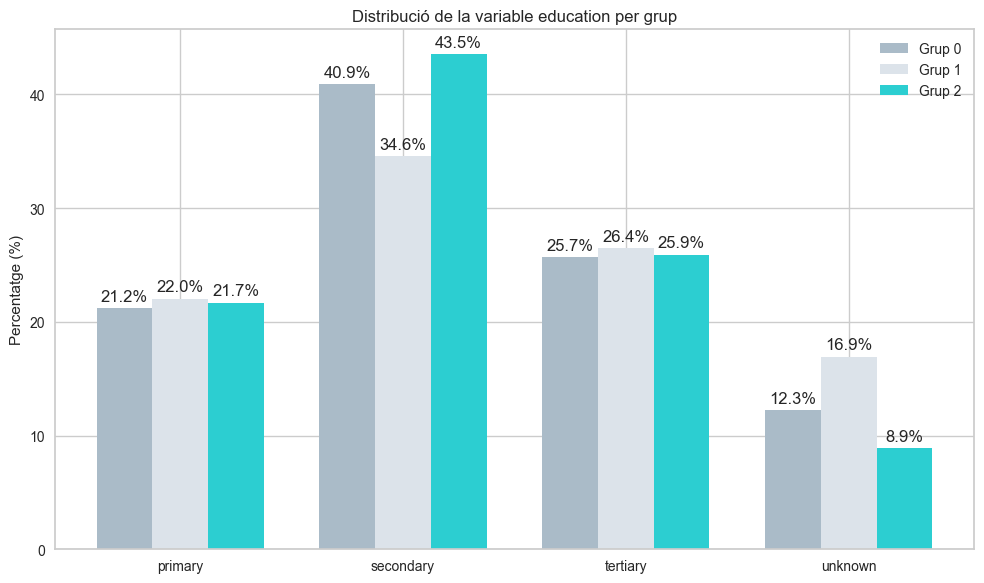

In [71]:

custom_palette = ["#AABBC8", "#DCE3EA", "#2CCED1", "#5F6F81", "#2E2F36"]  
sns.set_palette(sns.color_palette(custom_palette))

# Definir l'ordre desitjat per a education
ordre_education = ['primary', 'secondary', 'tertiary', 'unknown']

# Calcular percentatge d'education per grup
percentatge_per_grup = df_total.groupby(['grup', 'education']).size().unstack(fill_value=0)

# Reindexar les columnes segons l'ordre desitjat
percentatge_per_grup = percentatge_per_grup[ordre_education]

# Convertir a percentatge dins de cada grup
percentatge_per_grup = percentatge_per_grup.div(percentatge_per_grup.sum(axis=1), axis=0) * 100

# Paràmetres per al gràfic
labels = ordre_education
x = np.arange(len(labels))  # posició de les categories
width = 0.25  # amplada de cada barra

fig, ax = plt.subplots(figsize=(10, 6))

# Barres per cada grup
rects0 = ax.bar(x - width, percentatge_per_grup.loc[0], width, label='Grup 0')
rects1 = ax.bar(x, percentatge_per_grup.loc[1], width, label='Grup 1')
rects2 = ax.bar(x + width, percentatge_per_grup.loc[2], width, label='Grup 2')

# Estètica
ax.set_ylabel('Percentatge (%)')
ax.set_title('Distribució de la variable education per grup')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=0)
ax.legend()

# Mostrar valors a sobre les barres
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.1f}%',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects0)
autolabel(rects1)
autolabel(rects2)

plt.tight_layout()
plt.show()


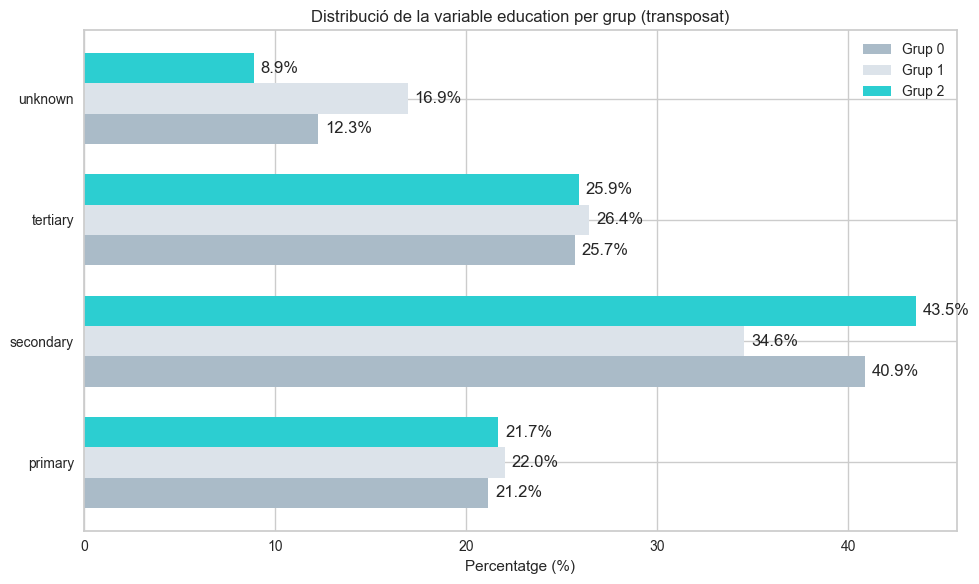

In [72]:


# Definir l'ordre desitjat per a education
ordre_education = ['primary', 'secondary', 'tertiary', 'unknown']

# Calcular percentatge d'education per grup
percentatge_per_grup = df_total.groupby(['grup', 'education']).size().unstack(fill_value=0)

# Reindexar les columnes segons l'ordre desitjat
percentatge_per_grup = percentatge_per_grup[ordre_education]

# Convertir a percentatge dins de cada grup
percentatge_per_grup = percentatge_per_grup.div(percentatge_per_grup.sum(axis=1), axis=0) * 100

# Transposar per graficar per nivells d'educació
df_plot = percentatge_per_grup.T  # index = education, columns = grup

# Paràmetres per al gràfic
labels = df_plot.index.tolist()
y = np.arange(len(labels))
width = 0.25

fig, ax = plt.subplots(figsize=(10, 6))

# Barres per cada grup (transposades)
rects0 = ax.barh(y - width, df_plot[0], height=width, label='Grup 0')
rects1 = ax.barh(y, df_plot[1], height=width, label='Grup 1')
rects2 = ax.barh(y + width, df_plot[2], height=width, label='Grup 2')

# Estètica
ax.set_xlabel('Percentatge (%)')
ax.set_title('Distribució de la variable education per grup (transposat)')
ax.set_yticks(y)
ax.set_yticklabels(labels)
ax.legend()

# Mostrar valors al costat de les barres
def autolabel_horizontal(rects):
    for rect in rects:
        width = rect.get_width()
        ax.annotate(f'{width:.1f}%',
                    xy=(width, rect.get_y() + rect.get_height() / 2),
                    xytext=(5, 0),  # offset horitzontal
                    textcoords="offset points",
                    ha='left', va='center')

autolabel_horizontal(rects0)
autolabel_horizontal(rects1)
autolabel_horizontal(rects2)

plt.tight_layout()
plt.show()


/var/folders/tj/x1zxmcgd19nbm3pz04lp5pv40000gn/T/ipykernel_9660/2823615729.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  freq = df_total.groupby(['age_bin', 'grup']).size().unstack(fill_value=0)


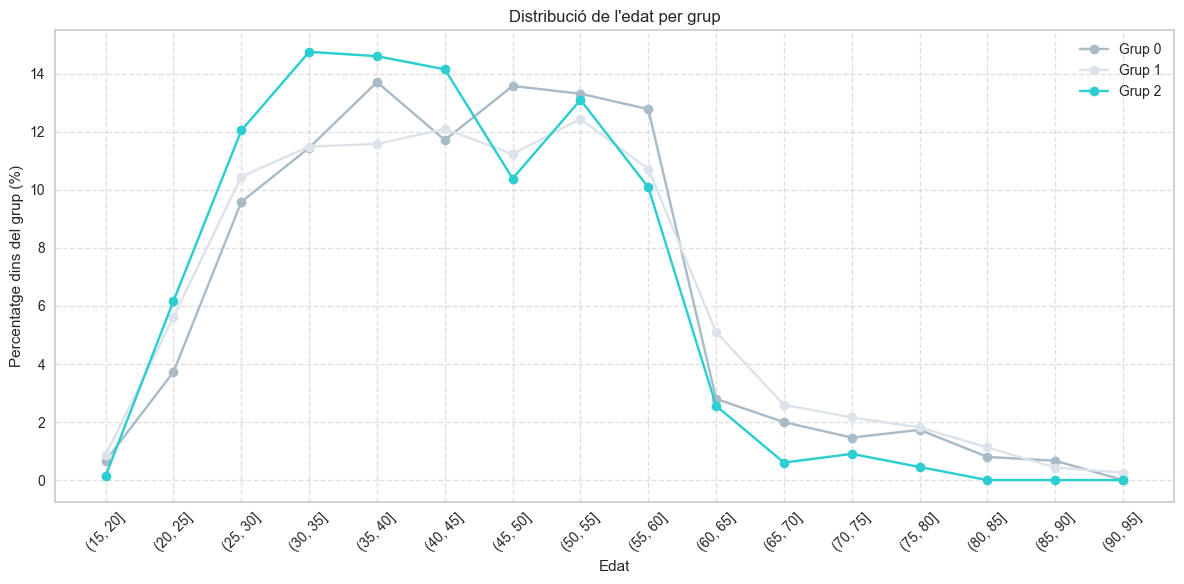

In [ ]:


# Crear intervals d’edat (bins)
bins = np.arange(15, 100, 5)  # intervals de 5 anys
df_total['age_bin'] = pd.cut(df_total['age'], bins=bins)

# Comptar per grup i interval
freq = df_total.groupby(['age_bin', 'grup']).size().unstack(fill_value=0)

# Convertir a percentatge dins de cada grup
freq_percent = freq.div(freq.sum(axis=0), axis=1) * 100

# Centrar les etiquetes dels bins
x_labels = freq.index.astype(str)
x_pos = [interval.mid for interval in freq.index]

# Dibuixar
plt.figure(figsize=(12, 6))

plt.plot(x_pos, freq_percent[0], label='Grup 0', marker='o')
plt.plot(x_pos, freq_percent[1], label='Grup 1', marker='o')
plt.plot(x_pos, freq_percent[2], label='Grup 2', marker='o')

plt.title('Distribució de l\'edat per grup')
plt.xlabel('Edat')
plt.ylabel('Percentatge dins del grup (%)')
plt.xticks(ticks=x_pos, labels=x_labels, rotation=45)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:

# Filtrar només el grup 2
df_grup2 = df_total[df_total['grup'] == 2]

# Agrupar per education i job
perfils = (
    df_grup2
    .groupby(['education', 'job'])
    .agg(
        comptador=('age', 'count'),
        edat_mitjana=('age', 'mean')
    )
    .reset_index()
)

# Seleccionar els 10 perfils més freqüents
top10 = perfils.sort_values(by='comptador', ascending=False).head(6)

# Crear taula amb plotly (comptador primer)
fig = go.Figure(data=[
    go.Table(
        header=dict(
            values=[
                '<b>Comptador</b>',
                '<b>Educació</b>',
                '<b>Feina</b>',
                '<b>Edat mitjana</b>'
            ],
            fill_color='lightgrey',
            align='left'
        ),
        cells=dict(
            values=[
                top10['comptador'],
                top10['education'],
                top10['job'],
                top10['edat_mitjana'].round(1)
            ],
            fill_color='white',
            align='left'
        )
    )
])

fig.update_layout(
    title='Top 6 perfils amb dos o més productes contractats',
    height=450
)

fig.show()


In [ ]:
import plotly.graph_objects as go

clust_data = {
    "Clúster": ["0", "1", "2"],
    "Edat mitjana": ["<b>56 anys</b>", "<b>28,8 anys</b>", "<b>41 anys</b>"],
    "Educació dominant": ["<b>Secundària</b>", "<b>Secundària i terciària</b>", "<b>Secundària</b>"],
    "Feina destacada": [
        "<b>Retirats, management</b>",
        "<b>Blue-collar, tècnics, serveis</b>",
        "<b>Blue-collar, tècnics</b>"
    ],
    "Perfil resumit": [
        "Adults grans consolidats",
        "Joves amb alta activitat i capacitat contractant",
        "Adults actius amb estabilitat laboral"
    ]
}

columns = list(clust_data.keys())
values = [clust_data[col] for col in columns]

# Comprovació addicional (opcional): assegurar longituds iguals
assert all(len(v) == len(values[0]) for v in values), "⚠️ Alguna llista té una longitud diferent!"

fig = go.Figure(data=[
    go.Table(
        header=dict(
            values=columns,
            fill_color='lightgrey',
            align='left',
            font=dict(size=13, color='black')
        ),
        cells=dict(
            values=values,
            fill_color='white',
            align='left',
            font=dict(size=12)
        )
    )
])

fig.update_layout(
    title='Perfil resumit per clúster',
    height=500
)

fig.show()


In [86]:
import plotly.graph_objects as go

# Paleta personalitzada
custom_palette = ["#AABBC8", "#DCE3EA", "#2CCED1", "#5F6F81", "#2E2F36"]

clust_data = {
    "Clúster": ["0", "1", "2"],
    "Edat mitjana": ["56 anys", "28,8 anys", "41 anys"],
    "Educació dominant": ["Secundària", "Secundària i terciària", "Secundària"],
    "Feina destacada": [
        "Retirats, management",
        "Blue-collar, tècnics, serveis",
        "Blue-collar, tècnics"
    ],
    "Perfil resumit": [
        "<b>Adults grans consolidats</b>",
        "<b>Joves amb alta activitat i capacitat contractant</b>",
        "<b>Adults actius amb estabilitat laboral</b>"
    ]
}

columns = list(clust_data.keys())
values = [clust_data[col] for col in columns]

# Comprovació: totes les llistes han de tenir la mateixa llargada
assert all(len(v) == len(values[0]) for v in values), "⚠️ Alguna llista té una longitud diferent!"

# Aplicar un color per fila (repetim la paleta per cada columna)
row_colors = [custom_palette[i] for i in range(len(values[0]))]
fill_colors = [[row_colors[row]] * len(columns) for row in range(len(row_colors))]

fig = go.Figure(data=[
    go.Table(
        header=dict(
            values=columns,
            fill_color='#2E2F36',
            align='left',
            font=dict(size=13, color='white')
        ),
        cells=dict(
            values=values,
            fill_color=fill_colors,
            align='left',
            font=dict(size=12, color='black')
        )
    )
])

fig.update_layout(
    title='Perfil resumit per clúster',
    height=500
)

fig.show()
